# Krzysztof Kalisiak, Geolocation Brain

## 1. Libraries and choosen Brain System import

In [1]:
from sklearn.metrics import root_mean_squared_error, r2_score
import gc
from torch.autograd import Variable
import torchvision.transforms as T

from GeoGuesserSystem import *

In [2]:
BR = system_loader('SYS_ID_grid0_full')

### 1.1 [Optional] transfer of parameters between models  

In [ ]:
#BR_t = system_loader('SYS_ID_grid0')
#with torch.no_grad():
#    for x, y in zip(list(BR.NN.mods.parameters()), list(BR_t.NN.mods.parameters())):
#        x.copy_(y)
#save_system(BR, 'SYS_ID_grid0_full')

#del BR_t
#torch.cuda.empty_cache()
#gc.collect()

## 2. Training sequence

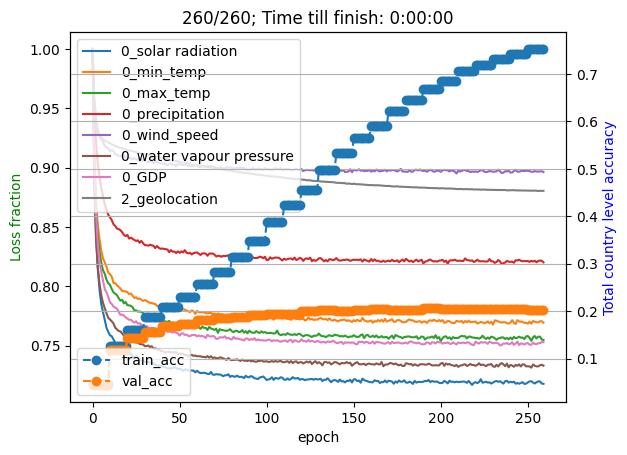

In [3]:

if __name__ == '__main__':

    BR.prepare_dataloaders()

    BR.train(260)
    save_system(BR, 'SYS_ID_grid0')

## 3. Testing sequence

In [3]:
BR.prepare_dataloaders()
#R.generate_test_main(on='test')

In [4]:
tt = BR.task_summary['geolocation'].copy()
tt = tt.applymap(lambda x: x[:12])
tt = tt.groupby('real')['pred'].value_counts().unstack(-1)
tt = tt.reindex(tt.index, axis=1).fillna(0)
test_acc = np.diag(tt).sum()/np.sum(tt.values, axis=None)
test_acc

0.4688626679777122

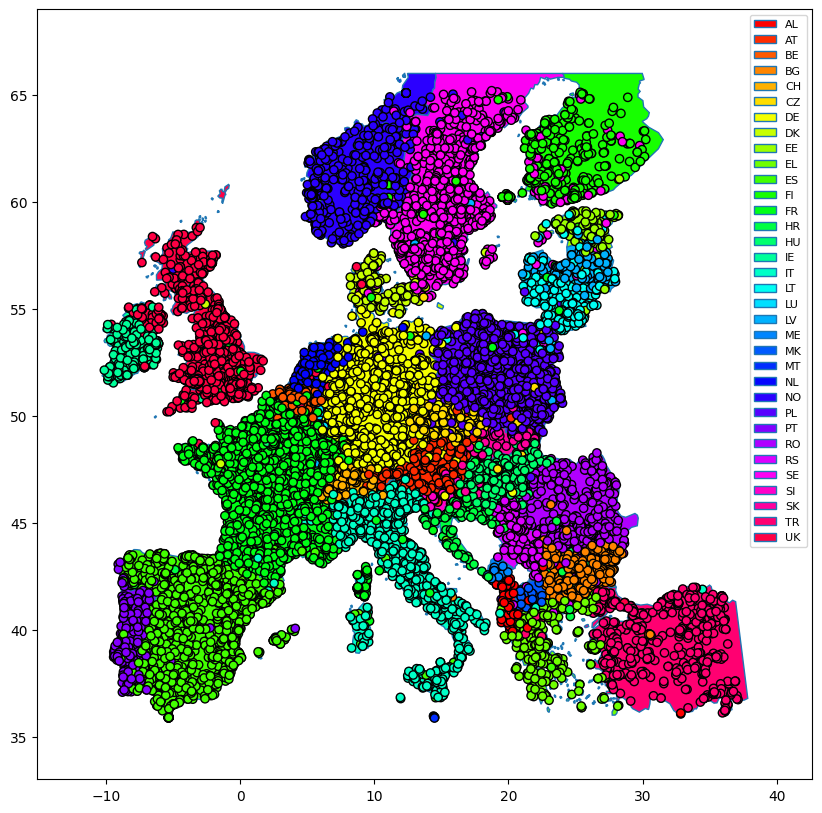

In [5]:
BR.metrics_and_plots(1)

In [8]:
r2_score(BR.task_summary['GDP']['real'], BR.task_summary['GDP']['pred'])

0.28912485535390686

In [7]:
save_system(BR, 'SYS_ID_grid0_full')

## 4. Saving system

In [7]:
save_system(BR, 'SYS5_d_blur')

## 5. Additional analysis for full models

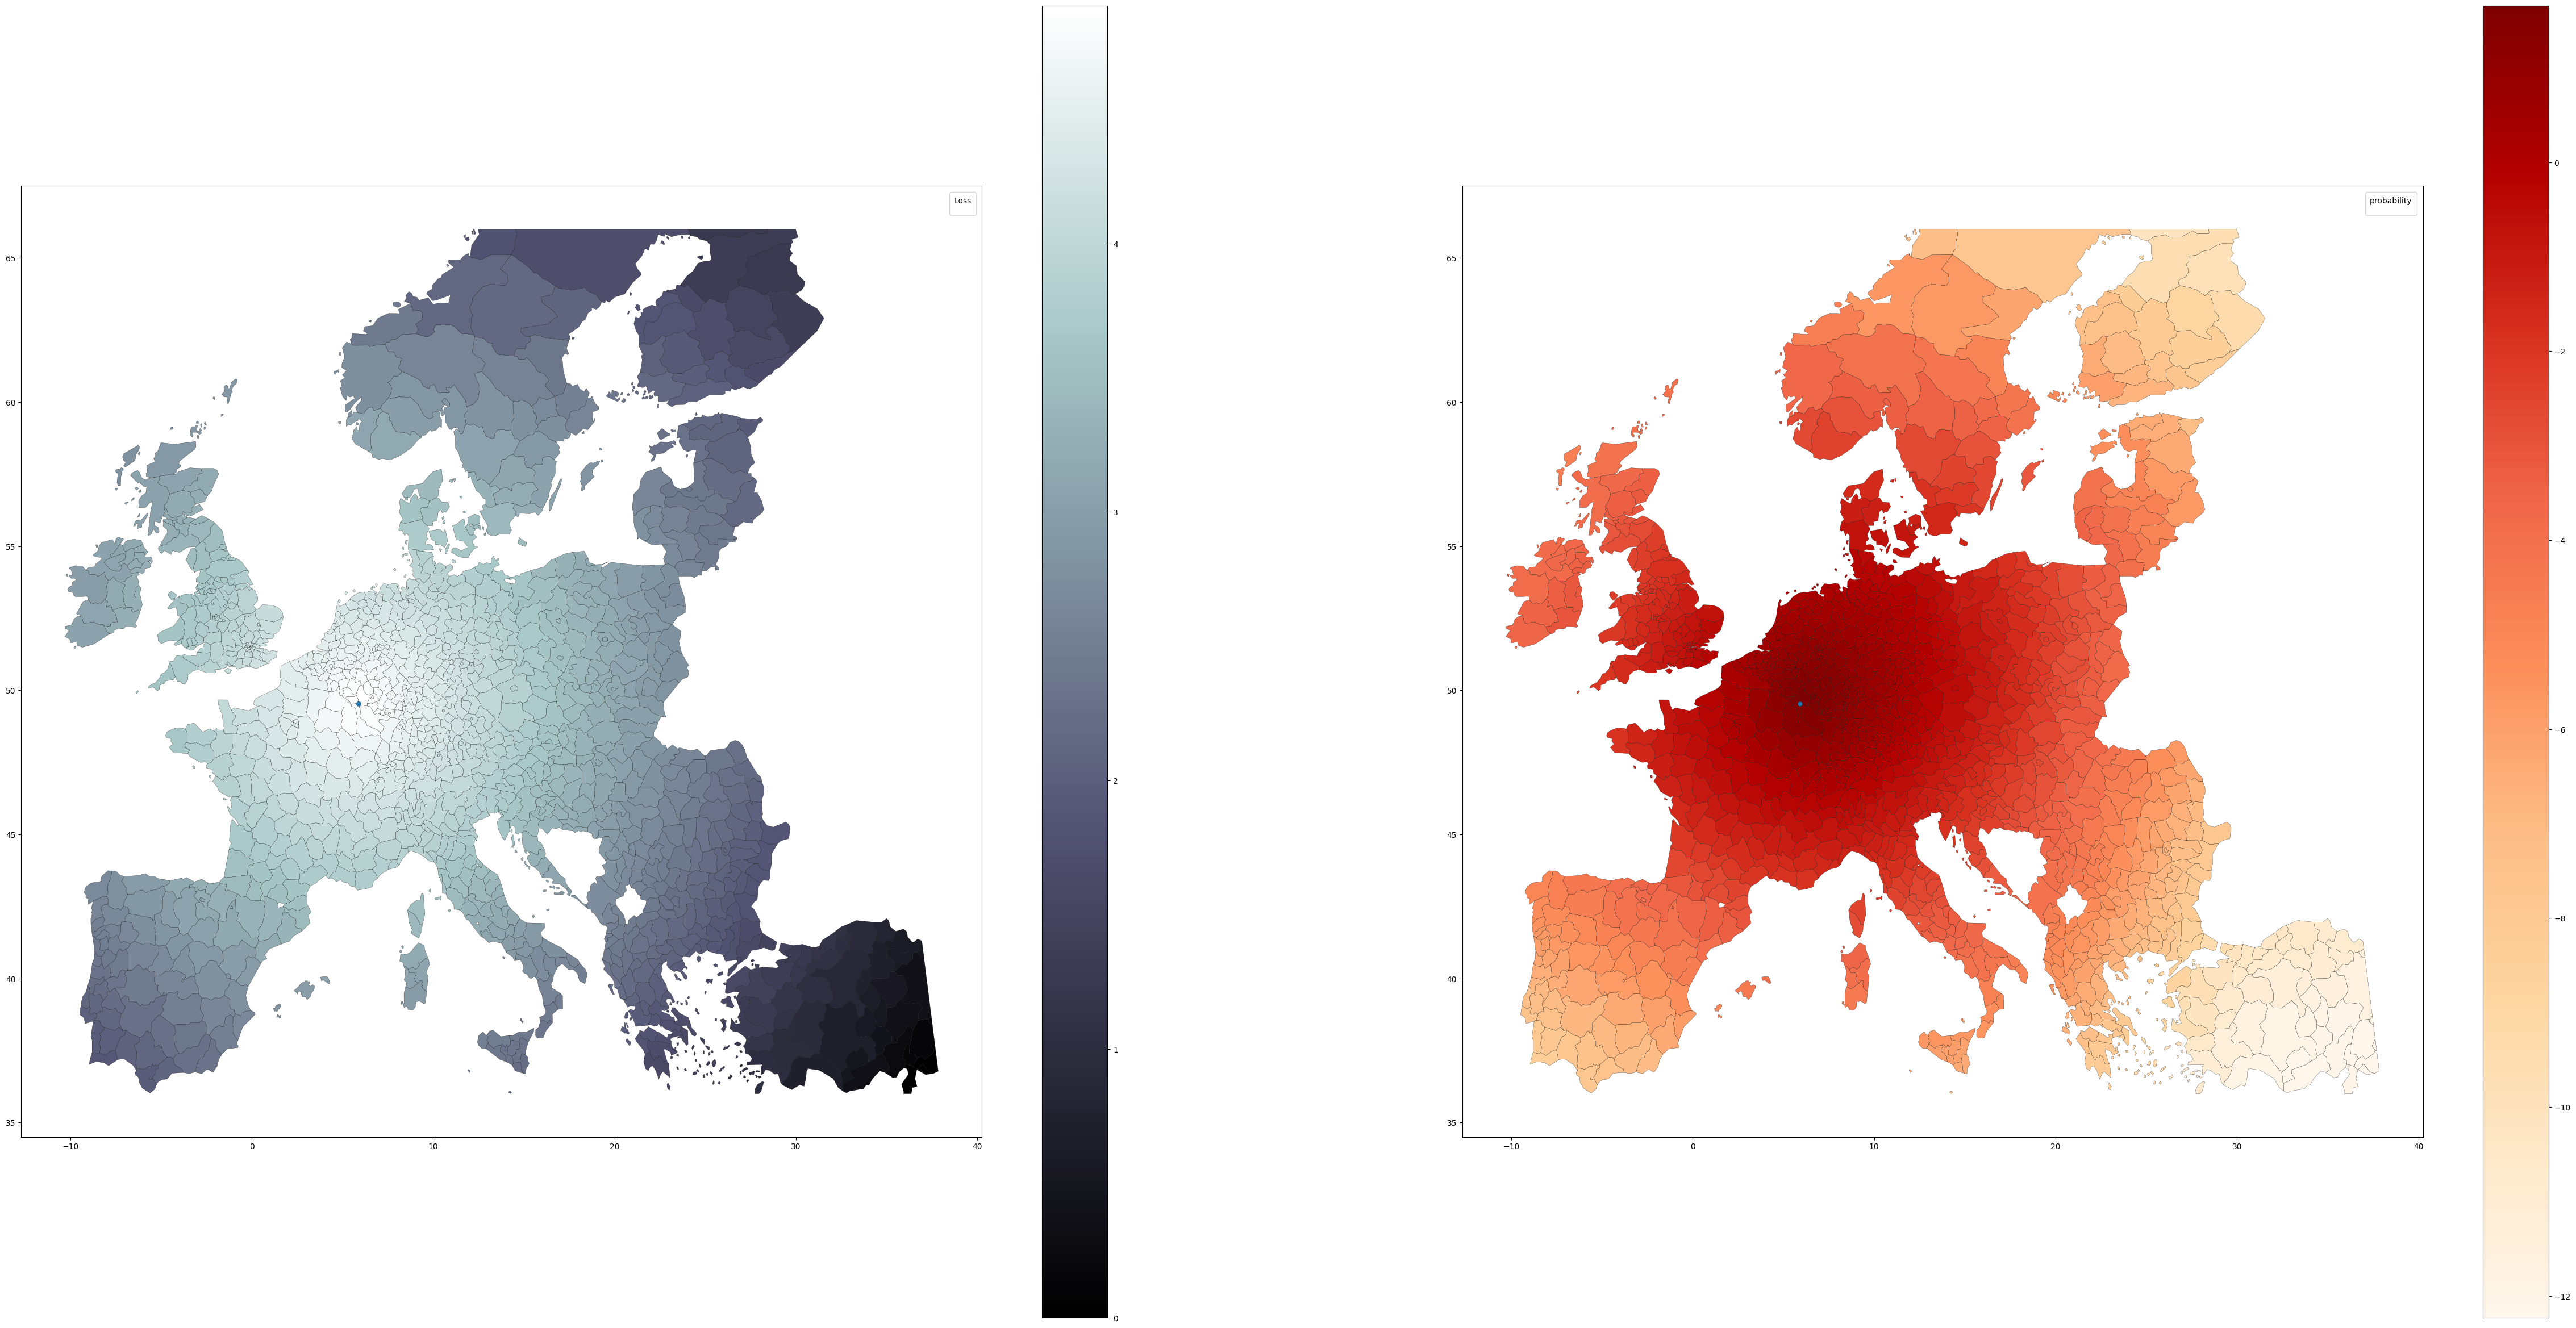

In [10]:
BR.prepare_dataloaders()
results = BR.asses_photo(BR.train_dataloader.dataset[1])

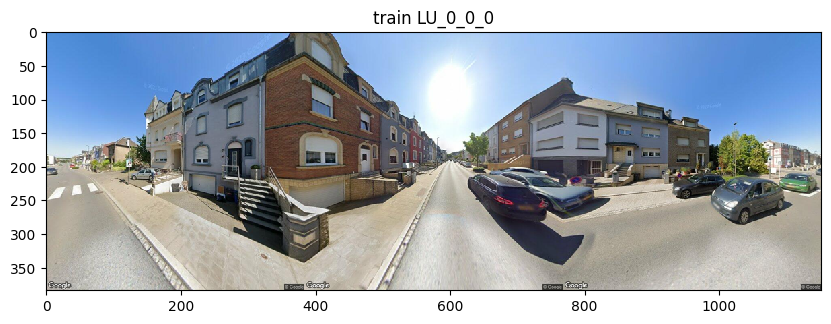

In [54]:
f = BR.extract_photo(1)

In [11]:
BR.prepare_dataloaders()

In [ ]:
results1 = BR.gradient_track(BR.test_dataloader.dataset[20], auxiliary_lvl=3, lvl=0, cam_type='ScoreCAM')

 76%|███████▋  | 55/72 [00:54<00:16,  1.01it/s]

In [ ]:
results2 = BR.gradient_track(BR.test_dataloader.dataset[1200], auxiliary_lvl=3, lvl=0, cam_type='ScoreCAM')

In [ ]:
results3 = BR.gradient_track(BR.test_dataloader.dataset[2400], auxiliary_lvl=3, lvl=0, cam_type='ScoreCAM')

In [ ]:
results4 = BR.gradient_track(BR.test_dataloader.dataset[3600], auxiliary_lvl=3, lvl=0, cam_type='ScoreCAM')

In [ ]:
results5 = BR.gradient_track(BR.test_dataloader.dataset[800], auxiliary_lvl=3, lvl=0, cam_type='ScoreCAM')

In [ ]:
results6 = BR.gradient_track(BR.test_dataloader.dataset[3100], auxiliary_lvl=3, lvl=0, cam_type='ScoreCAM')

In [10]:
save_system(BR, 'SYS_ID_grid0_full')

# Appendix

## A. Finetuning phase, GRID SEARCH
When correct configurations defined in model_configuration.py cell below train models

In [ ]:
res = {}

for k in model_configurations.system_configs.keys():
    
    BR = system_loader(k)

    if __name__ == '__main__':

        BR.prepare_dataloaders()

        BR.train(300, k)

        save_system(BR, k)
    
    del BR
    torch.cuda.empty_cache()
    gc.collect()

For already trained models cell below collects and compares results of different hiperparameters configurations

In [ ]:
top_res = {}
for x in tqdm.tqdm(glob.glob("/media/krzysztof-kalisiak/146d42f3-2f6b-45ae-bee9-48e549dda8c4/storage/_SYSTEMS_/*.pkl")):

    with open(x, 'rb') as f:

        print(x)

        system = pickle.load(f)
        system.train_dataloader = DataLoader(system.train_dataset, batch_size=system.batch_size, shuffle=True) 
        # num_workers=4, persistent_workers=True, multiprocessing_context='spawn', shuffle=True
        system.test_dataloader = DataLoader(system.test_dataset, batch_size=system.batch_size, shuffle=True)
        system.generate_test_main(on='test')
        
        side_tasks_RMSE = []
        for xx in ['GDP','max_temp','min_temp','precipitation','solar radiation','water vapour pressure','wind_speed']:
            side_tasks_RMSE.append(root_mean_squared_error(system.side_task_summary[xx]['real'], system.side_task_summary[xx]['pred']))

        p_l = []
        for precision in [2, 4, 6, 8, 12]:
            tt = system.task_summary['geolocation'].copy()
            tt = tt.applymap(lambda x: x[:precision])
            tt = tt.groupby('real')['pred'].value_counts().unstack(-1)
            tt = tt.reindex(tt.index, axis=1).fillna(0)
            test_acc = np.diag(tt).sum()/np.sum(tt.values, axis=None)
            p_l.append(test_acc)

        system.generate_test_main(on='train')
        p_l_tr = []
        for precision in [2, 4, 6, 8, 12]:
            tt = system.task_summary['geolocation'].copy()
            tt = tt.applymap(lambda x: x[:precision])
            tt = tt.groupby('real')['pred'].value_counts().unstack(-1)
            tt = tt.reindex(tt.index, axis=1).fillna(0)
            train_acc = np.diag(tt).sum()/np.sum(tt.values, axis=None)
            p_l_tr.append(train_acc)
    
    top_res[x.rsplit('/', 1)[1].split('.')[0]] = (p_l, p_l_tr, side_tasks_RMSE)

    del system
    torch.cuda.empty_cache()
    gc.collect()

with open('accuracy.pickle', 'wb') as handle:
    pickle.dump(top_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('accuracy.pickle', 'rb') as handle:
    top_res = pickle.load(handle)
def f1(x):
    d = pd.DataFrame({'test':x[0], 'train':x[1]})
    d.columns = pd.MultiIndex.from_tuples([(x.name, y) for y in d.columns])
    return d
res = pd.DataFrame(top_res).T.apply(f1, axis=1)
res = pd.concat(res.values, axis=1)
res = res.T
res.columns = ['level1', 'level2', 'level3', 'level4', 'level5']

res_oth = pd.DataFrame({k:v[2] for k,v in top_res.items()}).T
res_oth.columns = ['GDP','max_temp','min_temp','precipitation','solar radiation','water vapour pressure','wind_speed']

  0%|          | 0/41 [00:00<?, ?it/s]

/media/krzysztof-kalisiak/146d42f3-2f6b-45ae-bee9-48e549dda8c4/storage/_SYSTEMS_/SYS_ID_grid37.pkl


  0%|          | 0/41 [00:33<?, ?it/s]


Below presented results of subset of systems tested, with their performance on the side tasks, measured in RMSE on normalized data

In [19]:
res_oth.sort_values('GDP')

,GDP,max_temp,min_temp,precipitation,solar radiation,water vapour pressure,wind_speed
SYS_ID_grid8,0.835921,0.819304,0.848236,0.992540,0.803264,0.858579,1.022836
SYS_ID_grid5,0.840567,0.804135,0.839822,1.007257,0.788722,0.846366,1.008877
SYS_ID_grid31,0.842280,0.815179,0.849826,0.983484,0.799626,0.858273,1.004635
SYS_ID_grid34,0.842349,0.816402,0.852356,1.020776,0.803095,0.853836,1.029086
SYS_ID_grid1,0.842981,0.818949,0.856242,1.010712,0.806888,0.864486,1.017420
SYS_ID_grid39,0.843994,0.812049,0.845060,0.995750,0.796017,0.855894,1.028999
SYS_ID_grid42,0.844658,0.820199,0.846351,1.005187,0.795102,0.856209,1.030767
SYS_ID_grid33,0.845255,0.817061,0.845491,1.003469,0.797646,0.852964,1.001093
SYS_ID_grid21,0.845553,0.817052,0.850625,1.009441,0.802639,0.854994,1.019325
SYS_ID_grid7,0.845984,0.811491,0.843589,1.002275,0.795972,0.847236,1.029312


Below presented overfitting of model on the main task and different geolocational levels [1 to 5]

In [ ]:
res_overfit = res.unstack(-1)
res_overfit.columns = res_overfit.columns.swaplevel(0, 1)
res_overfit['train']/res_overfit['test']

,level1,level2,level3,level4,level5
SYS_ID_grid1,1.123119,1.313208,1.449770,1.580040,1.579683
SYS_ID_grid10,1.125540,1.290863,1.393384,1.519653,1.520061
SYS_ID_grid11,1.071460,1.176992,1.256898,1.372236,1.372852
SYS_ID_grid12,1.102350,1.250942,1.373599,1.539168,1.538646
SYS_ID_grid13,1.086488,1.193348,1.275528,1.326367,1.326448
SYS_ID_grid14,1.102705,1.244664,1.355225,1.514116,1.514063
SYS_ID_grid15,1.128027,1.347968,1.539046,1.819718,1.819758
SYS_ID_grid16,1.103436,1.247523,1.330805,1.446450,1.445939
SYS_ID_grid17,1.129116,1.316955,1.468883,1.641147,1.641018
SYS_ID_grid18,1.170648,1.468014,1.758453,2.227463,2.227233


Determining the winner model beolow, one with lowest ranking based score, ID 38 wins

In [9]:
r = []
for lvl in ['level1', 'level2', 'level3', 'level4', 'level5']:
    r.append(pd.Series({x:i for i, x in enumerate(res.loc[res.index.get_level_values(1)=='test'].sort_values(lvl, ascending=False).index.get_level_values(0))}))
pd.concat(r).groupby(level=0).sum().sort_values(ascending=True)

SYS_ID_grid38     17
SYS_ID_grid31     17
SYS_ID_grid36     19
SYS_ID_grid40     25
SYS_ID_grid3      28
SYS_ID_grid35     35
SYS_ID_grid6      39
SYS_ID_grid37     42
SYS_ID_grid39     42
SYS_ID_grid43     46
SYS_ID_grid42     48
SYS_ID_grid33     57
SYS_ID_grid32     60
SYS_ID_grid9      60
SYS_ID_grid30     63
SYS_ID_grid2      66
SYS_ID_grid5      66
SYS_ID_grid41     76
SYS_ID_grid34     85
SYS_ID_grid8      86
SYS_ID_grid15     89
SYS_ID_grid7     108
SYS_ID_grid12    115
SYS_ID_grid18    117
SYS_ID_grid17    124
SYS_ID_grid23    130
SYS_ID_grid27    130
SYS_ID_grid24    136
SYS_ID_grid4     139
SYS_ID_grid14    149
SYS_ID_grid10    151
SYS_ID_grid20    158
SYS_ID_grid1     159
SYS_ID_grid21    160
SYS_ID_grid16    167
SYS_ID_grid25    168
SYS_ID_grid22    172
SYS_ID_grid26    176
SYS_ID_grid11    183
SYS_ID_grid13    194
SYS_ID_grid19    198
dtype: int64

## B. GAN powered image generation, (didnt't work)

Attempt to generate artificial images that would maximise model's propability of choosing given class, this simple approach didnt work as Generator and Discriminator weren't trained at the same time.

In [ ]:
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

nc = 3

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.nc = 3
        self.ngf = 64
        self.nz = 100

        self.embed_layer = nn.Embedding(1188, self.nz)

        self.main = nn.Sequential(

            # input is Z, going into a convolution
            nn.ConvTranspose2d( self.nz+self.nz, self.ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.ngf * 32, self.ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 16),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(self.ngf * 16, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( self.ngf * 4, self.ngf * 2, 4, 3, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( self.ngf * 2, self.ngf, 4, 3, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( self.ngf, self.nc, 4, 3, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, noise, input):

        x_embed = self.embed_layer(input)[:, :, None, None]
        x = torch.cat([noise, x_embed], 1)
        return self.main(x)

netG = Generator().to('cuda')

optimizerG = optim.Adam(netG.parameters())

BR.prepare_dataloaders()

In [ ]:
_, preprocess = open_clip.create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384', device=DEVICE)
del _

loss = nn.CrossEntropyLoss()
BR.train_dataloader = DataLoader(BR.train_dataset, batch_size=6, 
                                    num_workers=2, persistent_workers=True, 
                                    multiprocessing_context='spawn', shuffle=True) 

In [ ]:
transform = T.ToPILImage()
num_epochs = 100
d_values = {v:i for i, v in enumerate(BR.shp.index.values)}
losses = []
for epoch in range(16):
    print(epoch)
    loss_b = []

    for dummy in tqdm.tqdm(BR.train_dataloader, total=len(BR.train_dataloader)):

        netG.zero_grad()
        noise = Variable(torch.randn(len(dummy[1][4]), nz, 1, 1)).to('cuda')
        loc_codes = torch.Tensor([d_values[x] for x in dummy[1][4]]).to(torch.int32).to('cuda')
        generated_image = netG(noise, loc_codes)
        res = []

        for j in range(generated_image.shape[0]):
            res.append(transform(generated_image[j, :, :, :]))

        res = torch.stack([preprocess(y) for y in res], dim=0).to('cuda')
        reaction = BR.NN(res.detach())[1][0]
        real_y = BR.real_output_extract(dummy[1])[1][0]

        errG = loss(reaction, real_y)
        errG.backward()
        optimizerG.step()

        loss_b.append(errG.item())

    losses.append(np.mean(loss_b))
    torch.save(netG, 'generator.pt')

Starting Training Loop...
0


100%|██████████| 8163/8163 [1:03:22<00:00,  2.15it/s]


1


100%|██████████| 8163/8163 [1:04:22<00:00,  2.11it/s]


2


100%|██████████| 8163/8163 [1:04:25<00:00,  2.11it/s]


3


100%|██████████| 8163/8163 [1:04:26<00:00,  2.11it/s]


4


100%|██████████| 8163/8163 [1:04:28<00:00,  2.11it/s]


5


100%|██████████| 8163/8163 [1:04:21<00:00,  2.11it/s]


6


100%|██████████| 8163/8163 [1:04:23<00:00,  2.11it/s]


7


100%|██████████| 8163/8163 [1:04:29<00:00,  2.11it/s]


8


100%|██████████| 8163/8163 [1:04:28<00:00,  2.11it/s]


9


100%|██████████| 8163/8163 [1:04:27<00:00,  2.11it/s]


10


100%|██████████| 8163/8163 [1:04:25<00:00,  2.11it/s]


11


100%|██████████| 8163/8163 [1:04:23<00:00,  2.11it/s]


12


100%|██████████| 8163/8163 [1:04:30<00:00,  2.11it/s]


13


  0%|          | 22/8163 [00:10<1:06:36,  2.04it/s]


KeyboardInterrupt: 

Loss is not improving, model is stuck somewhere

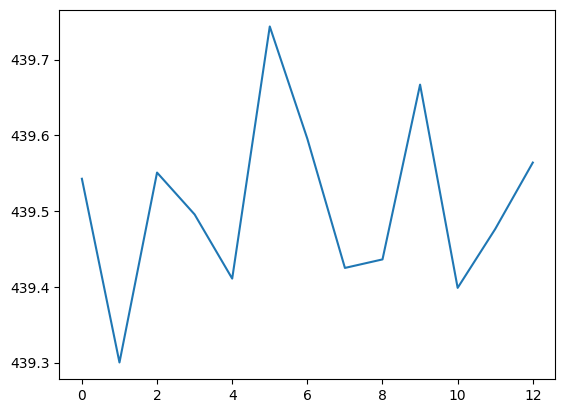

In [27]:
plt.plot(losses)

## C. Generation of embeddings

In [ ]:
baseline_model, preprocess = open_clip.create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384', device='cuda')
baseline_model = baseline_model.visual

res = {}
for x in tqdm.tqdm(glob.glob('embeddings/ViT-SO400M-14-SigLIP-384/*/*.pt')):

    res[x.split('384/')[1]] = torch.load(x)

torch.save(res, 'embeddings/ViT-SO400M-14-SigLIP-384/all_embeddings.pt')